In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
import sys
import h5py
import re

In [6]:
## read error from LOG file in MLP cases

WIDTH_LIST=np.array([36,52,75,105,150])
MLP_PATH_LIST = ['HIT_MLP_SIREN_NSNAP_20_NSX_'+str(x)+'_OMEGA_30.0_LSX_4_BS_80000/' for x in WIDTH_LIST]

MSE_MLP_LIST=[]
for PATH in MLP_PATH_LIST:
    fo = open('./compare_inference_speed_memory/MLP/'+PATH+'log', "r")
    line = fo.readlines()
    ll = ''
    for l in line:
        if 'Loss' in l:
            ll = l
    k=re.findall(r'0\.\d+', ll)
    MSE_MLP_LIST.append(float(k[0]))

In [7]:
## read error from LOG file in NIF cases

NIF_PATH_LIST =[
    'HIT_NIF_SIREN_NSNAP_20_NSX_36_OMEGA_30.0_LSX_4_NST_50_LST_2_NP_10_BS_10000/',
    'HIT_NIF_SIREN_NSNAP_20_NSX_52_OMEGA_30.0_LSX_4_NST_50_LST_2_NP_10_BS_5000/',
    'HIT_NIF_SIREN_NSNAP_20_NSX_75_OMEGA_30.0_LSX_4_NST_50_LST_2_NP_10_BS_10000/',
    'HIT_NIF_SIREN_NSNAP_20_NSX_105_OMEGA_30.0_LSX_4_NST_50_LST_2_NP_10_BS_1800/',
    'HIT_NIF_SIREN_NSNAP_20_NSX_150_OMEGA_30.0_LSX_4_NST_50_LST_2_NP_10_BS_700/',
]

MSE_NIF_LIST=[]
for PATH in NIF_PATH_LIST:
    fo = open('./compare_inference_speed_memory/NIF/'+PATH+'log', "r")
    line = fo.readlines()
    
    ll = ''
    for l in line:
        if 'Loss' in l:
            ll = l
    k=re.findall(r'0\.\d+', ll)
    MSE_NIF_LIST.append(float(k[0]))

## load a single 128^3/2 evaluation time

In [8]:
# 'HIT_MLP_SIREN_NSNAP_20_NSX_36_OMEGA_30.0_LSX_4_BS_80000',
# 'HIT_MLP_SIREN_NSNAP_20_NSX_52_OMEGA_30.0_LSX_4_BS_80000',
# 'HIT_MLP_SIREN_NSNAP_20_NSX_75_OMEGA_30.0_LSX_4_BS_80000',
# 'HIT_MLP_SIREN_NSNAP_20_NSX_105_OMEGA_30.0_LSX_4_BS_80000',
# 'HIT_MLP_SIREN_NSNAP_20_NSX_150_OMEGA_30.0_LSX_4_BS_80000']

# in min for 1 128^3 evaluation, using MLP model
TIME_LIST_U_MLP = \
np.array([0.02230353355407715,
0.03310766617457072,
0.04923235575358073,
0.07496410210927328,
0.11819320917129517])

TIME_LIST_DUDX_MLP = \
np.array([0.05024048884709676,
 0.07571551402409872,
 0.11086955865224203,  
 0.1675277312596639,
0.26678878466288247])

TIME_LIST_NIF_PARA = \
np.array([0.0007813731829325358,
0.0006220380465189616,
0.0006193876266479492,
0.0006228129069010417,
0.0006545464197794597
])

TIME_LIST_U_NIF = \
np.array([0.022025140126546223,
0.03287061850229899,
0.04912358125050863 ,
0.07469584544499715,
0.11844611167907715]) + TIME_LIST_NIF_PARA.mean()

TIME_LIST_DUDX_NIF=\
np.array([0.051134920120239256,
 0.07464396953582764,
 0.11141833066940307 ,
 0.16923366785049437,
0.26404133637746174
]) + TIME_LIST_NIF_PARA.mean()

# in GB
MEMORY_LIST_U_MLP = np.array([474.5,666.5,942.2,1302.3,1842.2])/1024
MEMORY_LIST_DUDX_MLP = np.array([1915.3,2539.5,4547.6 ,5087.2,7847.1])/1024

MEMORY_LIST_U_NIF = np.array([467.0, 659.4, 942.2,1297.6,1841.1])/1024
MEMORY_LIST_DUDX_NIF = np.array([2052.8,2960.5,4241.4 ,5499.4,7836.5])/1024

## compute the performance increase-percentage

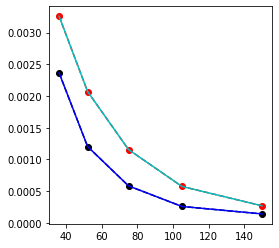

In [9]:
# 1. fit the curve of NIF and MLP
from scipy import interpolate
xnew = np.linspace(WIDTH_LIST.min(),WIDTH_LIST.max(),100,endpoint=True)

a_nif = interpolate.splrep(WIDTH_LIST, MSE_NIF_LIST, k=1, s=0)
y1 = interpolate.splev(xnew, a_nif, der=0)

a_mlp = interpolate.splrep(WIDTH_LIST, MSE_MLP_LIST, k=1, s=0)
y2 = interpolate.splev(xnew, a_mlp, der=0)

plt.figure(figsize=(4,4))
plt.plot(WIDTH_LIST, MSE_NIF_LIST,'k--o')
plt.plot(xnew, y1,'b-')

plt.plot(WIDTH_LIST, MSE_MLP_LIST,'r--o')
plt.plot(xnew, y2,'c-')

In [10]:
# 2. solve for the roots
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

mse_range = np.linspace(2.8e-4,2.1e-3,30,endpoint=True)
r_list_nif = []
r_list_mlp = []
for e in mse_range:
    _,i=find_nearest(y1,e)
    r_list_nif.append(xnew[i])
    _,i=find_nearest(y2,e)
    r_list_mlp.append(xnew[i])

r_list_mlp = np.array(r_list_mlp)
r_list_nif = np.array(r_list_nif)

r_list_mlp=np.vstack([r_list_mlp, mse_range]).T
r_list_nif=np.vstack([r_list_nif, mse_range]).T

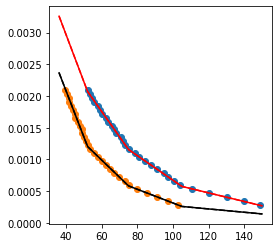

In [11]:
plt.figure(figsize=(4,4))
plt.plot(WIDTH_LIST, MSE_NIF_LIST,'k--')
plt.plot(xnew, y1,'k-')

plt.plot(WIDTH_LIST, MSE_MLP_LIST,'r--')
plt.plot(xnew, y2,'r-')

plt.scatter(r_list_mlp[:,0],r_list_mlp[:,1])
plt.scatter(r_list_nif[:,0],r_list_nif[:,1])

# compute CPU run time for forward and backward runtime

In [12]:
a_nif_runtime_f = interpolate.splrep(WIDTH_LIST, TIME_LIST_U_NIF, k=1, s=0)
a_nif_runtime_b = interpolate.splrep(WIDTH_LIST, TIME_LIST_DUDX_NIF, k=1, s=0)
a_nif_mem_f = interpolate.splrep(WIDTH_LIST, MEMORY_LIST_U_NIF, k=1, s=0)
a_nif_mem_b = interpolate.splrep(WIDTH_LIST, MEMORY_LIST_DUDX_NIF, k=1, s=0)

a_mlp_runtime_f = interpolate.splrep(WIDTH_LIST, TIME_LIST_U_MLP, k=1, s=0)
a_mlp_runtime_b = interpolate.splrep(WIDTH_LIST, TIME_LIST_DUDX_MLP, k=1, s=0)
a_mlp_mem_f = interpolate.splrep(WIDTH_LIST, MEMORY_LIST_U_MLP, k=1, s=0)
a_mlp_mem_b = interpolate.splrep(WIDTH_LIST, MEMORY_LIST_DUDX_MLP, k=1, s=0)

In [13]:
xmlp = r_list_mlp[:,0]
xnif = r_list_nif[:,0]

nif_runtime_f = interpolate.splev(xnif, a_nif_runtime_f, der=0)
nif_runtime_b = interpolate.splev(xnif, a_nif_runtime_b, der=0)
nif_mem_f = interpolate.splev(xnif, a_nif_mem_f, der=0)
nif_mem_b = interpolate.splev(xnif, a_nif_mem_b, der=0)

mlp_runtime_f = interpolate.splev(xmlp, a_mlp_runtime_f, der=0)
mlp_runtime_b = interpolate.splev(xmlp, a_mlp_runtime_b, der=0)
mlp_mem_f = interpolate.splev(xmlp, a_mlp_mem_f, der=0)
mlp_mem_b = interpolate.splev(xmlp, a_mlp_mem_b, der=0)

# compute relative reduction

In [14]:
width_relative_reduction_percent_WIDTH=100*(r_list_mlp[:,0] - r_list_nif[:,0])/r_list_mlp[:,0]
width_relative_reduction_percent_CPU_RT_F=100*(mlp_runtime_f - nif_runtime_f)/mlp_runtime_f
width_relative_reduction_percent_MEM_F=100*(mlp_mem_f - nif_mem_f)/mlp_mem_f
width_relative_reduction_percent_CPU_RT_B=100*(mlp_runtime_b - nif_runtime_b)/mlp_runtime_b
width_relative_reduction_percent_MEM_B=100*(mlp_mem_b - nif_mem_b)/mlp_mem_b


# PLOT!

mean (WIDTH) =  27.749664738690544
mean (CPU-RUNTIME - forward) =  30.173830150804577
mean (MEM - forward) =  27.12839216837302
mean (CPU-RUNTIME - backward) =  30.264224609237534
mean (MEM - backward) =  24.083862042523076


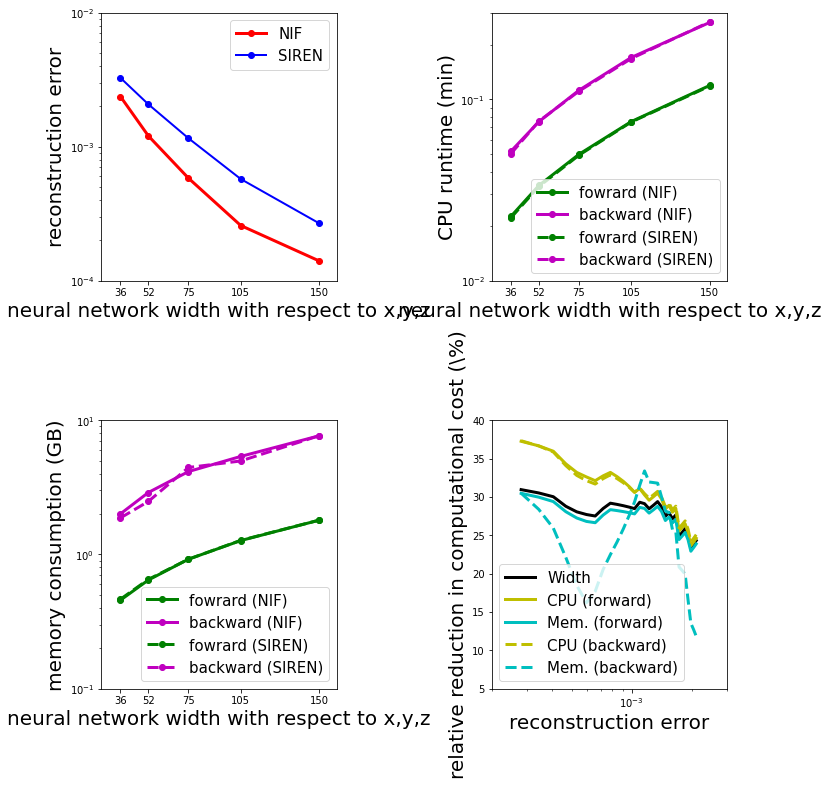

In [15]:
fig,ax = plt.subplots(2,2,figsize=(11,11))
FONT_SIZE = 15

ax[0,0].plot(WIDTH_LIST,MSE_NIF_LIST,'r-o',label='NIF',lw=3)
ax[0,0].plot(WIDTH_LIST,MSE_MLP_LIST,'b-o',label='SIREN',lw=2)
ax[0,0].set_ylim([0,4e-3])
ax[0,0].set_xlabel('neural network width with respect to x,y,z',fontsize=20)
ax[0,0].set_ylabel('reconstruction error',c='k',fontsize=20)

ax[0,1].plot(WIDTH_LIST,TIME_LIST_U_NIF,'g-o',label='fowrard (NIF)',lw=3)
ax[0,1].plot(WIDTH_LIST,TIME_LIST_DUDX_NIF,'m-o',label='backward (NIF)',lw=3)
ax[0,1].plot(WIDTH_LIST,TIME_LIST_U_MLP,'g--o',label='fowrard (SIREN)',lw=3)
ax[0,1].plot(WIDTH_LIST,TIME_LIST_DUDX_MLP,'m--o',label='backward (SIREN)',lw=3)
ax[0,1].set_ylabel('CPU runtime (min)',c='k',fontsize=20)
ax[0,1].set_xlabel('neural network width with respect to x,y,z',fontsize=20)

ax[1,0].plot(WIDTH_LIST,MEMORY_LIST_U_NIF,'g-o',label='fowrard (NIF)',lw=3)
ax[1,0].plot(WIDTH_LIST,MEMORY_LIST_DUDX_NIF,'m-o',label='backward (NIF)',lw=3)
ax[1,0].plot(WIDTH_LIST,MEMORY_LIST_U_MLP,'g--o',label='fowrard (SIREN)',lw=3)
ax[1,0].plot(WIDTH_LIST,MEMORY_LIST_DUDX_MLP,'m--o',label='backward (SIREN)',lw=3)
ax[1,0].set_ylabel('memory consumption (GB)',c='k',fontsize=20)
ax[1,0].set_xlabel('neural network width with respect to x,y,z',fontsize=20)

ax[0,0].set_ylim([1e-4,1e-2])
# ax.set_yticks([1e-4,2e-4,2e-3])
ax[0,1].set_ylim([1e-2,0.3])
ax[1,0].set_ylim([1e-1,10])
ax[0,0].set_xlim([25,160])
ax[0,1].set_xlim([25,160])
ax[1,0].set_xlim([25,160])
ax[0,0].set_xticks(WIDTH_LIST)
ax[0,1].set_xticks(WIDTH_LIST)
ax[1,0].set_xticks(WIDTH_LIST)
# ax[1].set_yticks(np.linspace(0,0.3,7,endpoint=True))
ax[0,1].tick_params(axis='y', colors='k')
ax[0,0].legend(loc='best',fontsize=FONT_SIZE)
ax[0,1].legend(loc='best',fontsize=FONT_SIZE)
ax[1,0].legend(loc='best',fontsize=FONT_SIZE)

ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')


ax[1,1].plot(r_list_mlp[:,1], width_relative_reduction_percent_WIDTH,'k-',label='Width',lw=3)
ax[1,1].plot(r_list_mlp[:,1], width_relative_reduction_percent_CPU_RT_F,'y-',label='CPU (forward)',lw=3)
ax[1,1].plot(r_list_mlp[:,1], width_relative_reduction_percent_MEM_F,'c-',label='Mem. (forward)',lw=3)
ax[1,1].plot(r_list_mlp[:,1], width_relative_reduction_percent_CPU_RT_B,'y--',label='CPU (backward)',lw=3)
ax[1,1].plot(r_list_mlp[:,1], width_relative_reduction_percent_MEM_B,'c--',label='Mem. (backward)',lw=3)


ax[1,1].set_xlabel('reconstruction error',fontsize=20)
ax[1,1].set_xscale('log')
ax[1,1].set_xlim([2e-4,3e-3])
ax[1,1].set_ylim([5,40])
ax[1,1].set_ylabel('relative reduction in computational cost (\%)',fontsize=20)
ax[1,1].legend(loc='best',fontsize=FONT_SIZE)

print('mean (WIDTH) = ',width_relative_reduction_percent_WIDTH.mean())
print('mean (CPU-RUNTIME - forward) = ',width_relative_reduction_percent_CPU_RT_F.mean())
print('mean (MEM - forward) = ',width_relative_reduction_percent_MEM_F.mean())
print('mean (CPU-RUNTIME - backward) = ',width_relative_reduction_percent_CPU_RT_B.mean())
print('mean (MEM - backward) = ',width_relative_reduction_percent_MEM_B.mean())


plt.tight_layout()

plt.savefig('./pngs/compare_mlp_nif.png',bbox_inches='tight')